# Graph structure to represent the network

In [32]:
import numpy as np
import pandas as pd
from typing import Dict, Any, List, Tuple
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import KDTree
import copy
from PIL import Image
import os


# bare bone graph structures
Ignore mostly see the next section

In [33]:

class Edge:
    def __init__(self, length: float, nodes: List['Node']) -> None:
        """Initialize an Edge object.

        Args:
            length (float): length in the edge (buffer).
        """
        self.length: float = length
        # add nodes to the edge with direction (from_node, to_node)
        
        self.connected_nodes = {}

        for node1 in nodes:
            for node2 in nodes:
                if node1 != node2:
                    self.connected_nodes[node1] = node2
                    self.connected_nodes[node2] = node1
                    

class Node:
    def __init__(self, value: Any, intersection_parameters_dic: Dict=None) -> None:
        """Initialize a Node object.

        Args:
            value (Any): Value stored in the node.
        """
        self.value: Any = value
        self.neighbors: Dict[Any, str] = {}  # Dict to hold neighboring nodes based on direction
        self.edges: Dict[str, Edge] = {}  # Dict to hold edges based on direction
        self.intersection = Intersection(name=value, **intersection_parameters_dic)


    def add_neighbor(self, direction: str, node: Any, edge: Edge) -> None:
        """Add a neighboring node and edge in a particular direction.

        Args:
            direction (str): Directional indicator ('N', 'W', 'E', 'S') for the edge.
            node (Any): Neighboring node.
            edge (Edge): Edge connecting the nodes.
        """
        if direction not in self.edges.keys():
            self.neighbors[direction] = node
            self.edges[direction] = edge

    def __hash__(self) -> int:
        """Custom hash function for the Node object."""
        return hash(self.value)
    
    def __eq__(self, __value: object) -> bool:
        """Custom equality function for the Node object."""
        if isinstance(__value, Node):
            return self.value == __value.value
        return False

    def __str__(self) -> str:
        """Custom representation of the Node object."""
        neighbors_info = "\n".join([f"  {direction}: {str(neighbor)}" for direction, neighbor in self.neighbors.items()])
        return f"Node value: {self.value}\nNeighbors:\n{neighbors_info}"

class Graph:
    def __init__(self, intersection_parameter_dic: Dict) -> None:
        """Initialize a Graph object."""
        self.opposite_d = {'N': 'S', 'E':'W', 'S':'N', 'W':'E'}
        self.nodes: Dict[Any, Node] = {}
        self.input_nodes = []  # List of input nodes
        self.graph_structure = None
        self.intersection_parameter_dic = intersection_parameter_dic

    def add_node(self, value: Any) -> None:
        """Add a node to the graph.

        Args:
            value (Any): Value to be stored in the node.
        """
        if value.startswith('in'):
            self.input_nodes.append(value)

        else: 
            if value not in self.nodes:           
                self.nodes[value] = Node(value, intersection_parameters_dic=self.intersection_parameter_dic)
            

    def add_edge(self, from_node: Any, to_node: Any, length: float, dir: str) -> None:
        """Add an edge (buffer) between two nodes.

        Args:
            from_node (Any): Starting node of the edge.
            to_node (Any): Ending node of the edge.
            length (Float): length associated with the edge.
        """
        edge = Edge(length=length, nodes=[from_node, to_node])
        self.nodes[from_node].add_neighbor(dir, to_node, edge)
        self.nodes[to_node].add_neighbor(self.opposite_d[dir], from_node, edge)

    def add_from_dict(self, graph_structure: Dict[Any, Tuple[int, List[Tuple[Any, float, str]]]]) -> None:
        """Add nodes and edges to the graph based on the provided dictionary.

        Args:
            graph_structure (Dict): Structure defining nodes, lengths, and connections.
        """
        self.graph_structure = graph_structure
        for node, (length, connections) in graph_structure.items():
            self.add_node(node)
            for neighbor, neighbor_length, dir in connections:
                self.add_node(neighbor)
                self.add_edge(node, neighbor, neighbor_length, dir)

    def draw_graph(self) -> None:
        """Draw the graph using NetworkX and Matplotlib."""
        G = nx.MultiGraph()
        added_edges = set()

        for node in self.nodes.values():
            G.add_node(str(node.value))
            for direction, connected_node in node.neighbors.items():
                edge_key = tuple(sorted([str(node.value), str(connected_node)]))
                edge = node.edges[direction]
                if edge_key not in added_edges:
                    G.add_edge(str(node.value), str(connected_node), length=edge.length)
                    added_edges.add(edge_key)

        pos = nx.spring_layout(G)
        labels = {str(node.value): str(node.value) for node in self.nodes.values()}
        edge_labels = {(u, v): str(data['length']) for u, v, data in G.edges(data=True)}

        nx.draw(G, pos, with_labels=True, labels=labels, node_size=800, node_color='skyblue', font_weight='bold', arrows=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
        plt.title("Graph Visualization")
        plt.show()


    def get_rectangular_grid_position(self):
        connected_nodes = set()
        for node, (_, neighbors) in graph_structure.items():
            connected_nodes.add(node)
            for neighbor, _, _ in neighbors:
                connected_nodes.add(neighbor)

        num_nodes = len(connected_nodes)
        num_cols = int(num_nodes ** 0.5) + 1

        # Get the first node in the graph_structure and assign it to (1, 1)
        first_node = next(iter(graph_structure.keys()))
        node_positions = {first_node: (1, 1)}

        # Assign positions based on cardinal directions (North, East, West, South) from the initial node
        directions = {'N': (0, 1), 'E': (1, 0), 'W': (-1, 0), 'S': (0, -1)}
        assigned_nodes = set([first_node])

        for node, (num_neighbors, neighbors) in graph_structure.items():
            if node in node_positions:
                x, y = node_positions[node]
                for neighbor, _, direction in neighbors:
                    if neighbor not in assigned_nodes:
                        dx, dy = directions[direction]
                        node_positions[neighbor] = (x + dx, y + dy)
                        assigned_nodes.add(neighbor)
        return node_positions

    
    def draw_rectangular_grid(self):
        
        node_positions = self.get_rectangular_grid_position()
        # Plotting the graph in a rectangular grid
        plt.figure(figsize=(8, 6))

        
        # Draw edges
        for node, (_, neighbors) in self.graph_structure.items():
            if node in node_positions:
                x1, y1 = node_positions[node]
                for neighbor, length, _ in neighbors:
                    if neighbor in node_positions:
                        x2, y2 = node_positions[neighbor]
                        plt.plot([x1, x2], [y1, y2], linestyle='-', color='black', zorder=1)
                        if node.startswith('in') or neighbor.startswith('in'):
                            continue
                        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                        plt.text(mid_x+0.05, mid_y+0.06, str(length), ha='center', va='center', fontsize=10, fontweight='bold', zorder=2)

        # Draw nodes
        for node, pos in node_positions.items():
            if node.startswith('in'):
                continue
            plt.scatter(pos[0], pos[1], s=500, color='skyblue', edgecolors='black', zorder=2)
            plt.text(pos[0], pos[1], node, ha='center', va='center', fontsize=12, fontweight='bold', zorder=3)
        
        plt.title('Graph Laid Out on a Rectangular Grid')
        plt.axis('off')  # Hide the axis
        plt.grid(visible=True)
        plt.show()


    def draw_graph_2(self) -> None:
        """Draw the graph using NetworkX and Matplotlib in a rectangular grid layout."""
        G = nx.MultiGraph()
        added_edges = set()
        pos = self.get_rectangular_grid_position()

        for node in self.nodes.values():
            G.add_node(str(node.value))

        for node in self.nodes.values():
            for direction, connected_node in node.neighbors.items():
                edge_key = tuple(sorted([str(node.value), str(connected_node)]))
                edge = node.edges[direction]
                if edge_key not in added_edges:
                    G.add_edge(str(node.value), str(connected_node), length=edge.length)
                    added_edges.add(edge_key)

        labels = {str(node.value): str(node.value) for node in self.nodes.values()}
        edge_labels = {(u, v): str(data['length']) for u, v, data in G.edges(data=True)}

        nx.draw(G, pos, with_labels=True, labels=labels, node_size=800, node_color='skyblue', font_weight='bold', arrows=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
        plt.title("Graph Visualization - Rectangular Grid Layout")
        plt.show()



# Example of using the Graph class

# Create a graph instance
graph = Graph()

# Define the graph structure
graph_structure: Dict[Any, Tuple[int, List[Tuple[Any, int, str]]]] = {
    'A': (4, [('in1', 0, 'N'), ('B', 1, 'E'), ('D', 2, 'S'), ('in2', 0, 'W')]),
    'B': (4, [('in3', 0, 'N'), ('C', 3, 'E'), ('E', 3, 'S'), ('A', 1, 'W')]),
    'C': (4, [('in4', 0, 'N'), ('in5', 0, 'E'), ('F', 3, 'S'), ('B', 3, 'W')]),
    'D': (4, [('A', 2, 'N'), ('E', 3, 'E'), ('in6', 0, 'S'), ('in7', 0, 'W')]),
    'E': (4, [('B', 3, 'N'), ('F', 3, 'E'), ('in8', 0, 'S'), ('D', 3, 'W')]),
    'F': (4, [('C', 3, 'N'), ('in9', 0, 'E'), ('in10', 0, 'S'), ('E', 3, 'W')])
}

# Add nodes and edges to the graph
graph.add_from_dict(graph_structure)

# Draw the graph
graph.draw_graph()
graph.draw_graph_2()
graph.draw_rectangular_grid()



TypeError: __init__() missing 1 required positional argument: 'intersection_parameter_dic'

In [34]:
from typing import Dict, Any, Tuple, List


def generate_graph(rows: int, cols: int, length=None) -> Dict[Any, Tuple[int, List[Tuple[Any, int, str]]]]:
    directions = ['N', 'E', 'S', 'W']
    opposite_d = {'N': 'S', 'E':'W', 'S':'N', 'W':'E'}
    graph_structure = {}

    def get_random_length():
        return np.random.randint(1, 10) if length is None else length
    fill_k = 0
    for i in range(rows):
        for j in range(cols):
            node_name = str(i * cols + j)
            neighbors = []
            if node_name in graph_structure.keys():
                neighbors = neighbors
            for direction in directions:
                neighbor = None
                if direction == 'N' and i > 0:
                    neighbor = (str((i - 1) * cols + j), get_random_length(), direction)
                elif direction == 'E' and j < cols - 1:
                    neighbor = (str(i * cols + (j + 1)), get_random_length(), direction)
                elif direction == 'S' and i < rows - 1:
                    neighbor = (str((i + 1) * cols + j), get_random_length(), direction)
                elif direction == 'W' and j > 0:
                    neighbor = (str(i * cols + (j - 1)), get_random_length(), direction)
                else:
                    # Add filler nodes for edges without neighbors
                    neighbor = ('in' + str(fill_k), 0, direction)
                    graph_structure[neighbor[0]] = (1, [(node_name, neighbor[1], opposite_d[direction])])
                    fill_k+=1
                neighbors.append(neighbor)
                

            graph_structure[node_name] = (len(neighbors), neighbors)
    
    return graph_structure

# Generate a graph with 2 rows and 3 columns
generated_graph = generate_graph(2, 3)
generated_graph


{'in0': (1, [('0', 0, 'S')]),
 'in1': (1, [('0', 0, 'E')]),
 '0': (4, [('in0', 0, 'N'), ('1', 7, 'E'), ('3', 4, 'S'), ('in1', 0, 'W')]),
 'in2': (1, [('1', 0, 'S')]),
 '1': (4, [('in2', 0, 'N'), ('2', 6, 'E'), ('4', 6, 'S'), ('0', 2, 'W')]),
 'in3': (1, [('2', 0, 'S')]),
 'in4': (1, [('2', 0, 'W')]),
 '2': (4, [('in3', 0, 'N'), ('in4', 0, 'E'), ('5', 8, 'S'), ('1', 2, 'W')]),
 'in5': (1, [('3', 0, 'N')]),
 'in6': (1, [('3', 0, 'E')]),
 '3': (4, [('0', 5, 'N'), ('4', 9, 'E'), ('in5', 0, 'S'), ('in6', 0, 'W')]),
 'in7': (1, [('4', 0, 'N')]),
 '4': (4, [('1', 3, 'N'), ('5', 1, 'E'), ('in7', 0, 'S'), ('3', 8, 'W')]),
 'in8': (1, [('5', 0, 'W')]),
 'in9': (1, [('5', 0, 'N')]),
 '5': (4, [('2', 6, 'N'), ('in8', 0, 'E'), ('in9', 0, 'S'), ('4', 1, 'W')])}

In [35]:
# Example of using the Graph class

# Create a graph instance
graph = Graph()

# Define the graph structure
graph_structure = generate_graph(3,4, length=1)

# Add nodes and edges to the graph
graph.add_from_dict(graph_structure)

# Draw the graph
graph.draw_graph_2()
graph.draw_rectangular_grid()

TypeError: __init__() missing 1 required positional argument: 'intersection_parameter_dic'

In [ ]:
def find_path(graph, start_node, end_node):

    opposite_d = {'N': 'S', 'E':'W', 'S':'N', 'W':'E'}
    visited = set()
    queue = deque([(start_node, [])])

    
    def determine_turn(current_dir, next_dir):
        if current_dir == next_dir or next_dir == opposite_d[current_dir]:
            return 'F'
        elif current_dir == 'N' and next_dir == 'E':
            return 'L'
        elif current_dir == 'N' and next_dir == 'W':
            return 'R'
        elif current_dir == 'E' and next_dir == 'S':
            return 'L'
        elif current_dir == 'E' and next_dir == 'N':
            return 'R'
        elif current_dir == 'S' and next_dir == 'W':
            return 'L'
        elif current_dir == 'S' and next_dir == 'E':
            return 'R'
        elif current_dir == 'W' and next_dir == 'N':
            return 'L'
        elif current_dir == 'W' and next_dir == 'S':
            return 'R'

    while queue:
        current_node, path = queue.popleft()

        if current_node == end_node:
            # path = [start_node] + path
            # print(f"Path found: {' -> '.join(str(p) for p in path)}")
            formatted_path = {}
            for i in range(len(path) - 1):
                # print(path[i])
                node, direction = path[i]
                next_node, next_direction = path[i + 1]
               
                turn = determine_turn(direction, opposite_d[next_direction])
                
                formatted_path.update({next_node: {"in_d": direction, 
                                                   "in_l": turn, 
                                                   "out_d": opposite_d[next_direction]}})
            
            return formatted_path

        if current_node not in visited:
            visited.add(current_node)

            _, neighbors = graph[current_node]
            # print(current_node, neighbors)
            for neighbor, _, direction in neighbors:
                new_path = list(path)
                new_path.append( (current_node, opposite_d[direction]))
                queue.append((neighbor, new_path))
    print("No path found.")
    return None


# Assuming you already have a generated_graph using the generate_graph function

# Find a path from 'in1' to 'in6'
path = find_path(graph_structure, 'in8', 'in2')

path

{'8': {'in_d': 'S', 'in_l': 'F', 'out_d': 'N'},
 '4': {'in_d': 'S', 'in_l': 'F', 'out_d': 'N'},
 '0': {'in_d': 'S', 'in_l': 'R', 'out_d': 'E'},
 '1': {'in_d': 'W', 'in_l': 'L', 'out_d': 'N'}}

## simulation environemnt setup

In [48]:
class Vehicle:
    def __init__(self, path, arrival_time: float, graph:Graph, min_speed: float=30, max_speed: float=50):
        self.min_speed = min_speed
        self.max_speed = max_speed
        self.path = path
        self.graph = graph
        # create a df to store arrival and departure times for nodes in the path with following structure {'node': {'in_d': arrival_direction, 'in_l': arrival lane, 'out_d': departure_direction }}}
        self.node_times = pd.DataFrame(columns=['node', 'arrival_direction', 'arrival_lane', 'arrival_time', 'departure_time'])
        # intialise the arrival time for the first node in the path
        # initialise the nodes_times with node from nodes and arrival lane and direction from path and set times to np.nan
        for node in path:
            node_deets = pd.Series({'node': node,
                                    'arrival_direction': path[node]['in_d'],
                                    'arrival_lane': path[node]['in_l'],
                                    'arrival_time': np.nan,
                                    'departure_time': np.nan
                                    })

            self.node_times = pd.concat([self.node_times, node_deets.to_frame().T], ignore_index=True)


        self.node_times['arrival_time'][0] = arrival_time
        self.current_node_index = 0
        self.curent_node = self.node_times.loc[self.current_node_index, 'node']
        self.arrival_lane = self.node_times.loc[self.current_node_index, 'arrival_lane']
        self.arrival_direction = self.node_times.loc[self.current_node_index, 'arrival_direction']
        self.graph.nodes[self.curent_node].intersection.insert_vehicle(vehicle=self, 
                                                                       lane=self.arrival_lane, 
                                                                       direction=self.arrival_direction)
        self.arrived_at_node = False
        self.reached_destination = False

        

    def get_current_speed(self):
        return np.random.uniform(self.min_speed, self.max_speed)

    def step(self, current_time, next_state: X_state, action: Tuple[List[str], List[str]], safe_right_turn=False):
        # move the vehicle to the next node in the path and update the departure time for the previous node
        # update the arrival time for the current node
        # set the in_buffer flag to False
        # if the vehicle has reached the end of the path, set the departure time for the current node
        # and set the in_buffer flag to False
        # if the vehicle has not reached the end of the path, set the in_buffer flag to True
        # and update the arrival time for the next node in the path

        # arrival 
        if current_time >= self.node_times.loc[self.current_node_index, 'arrival_time'] and not self.arrived_at_node:
            current_node = self.curent_node
            current_node_index = self.current_node_index
            direction = self.node_times.loc[current_node_index, 'arrival_direction']
            lane = self.node_times.loc[current_node_index, 'arrival_lane']
            self.arrived_at_node = True
            next_state.state[direction][lane] += 1
        
        departed = False
        # departure
        if self.arrived_at_node:
            # vehicle is at this node
            # check if the vehicle can depart and then depart
            if (self.arrival_lane == 'R' and safe_right_turn) \
                 or (self.arrival_direction in action[0] and self.arrival_lane in action[1]):
               departed = self.depart_vehicle_from_current_node(current_time)
          
        return departed
    
    def depart_vehicle_from_current_node(self, current_time):
        # get currnt and next node
        departed = False
        current_node = self.curent_node
        current_node_index = self.current_node_index
        
        # check if the current node is the last node in the path
        if current_node_index == len(self.node_times) - 1:
            # reached destination
            self.reached_destination = True
            self.node_times.loc[current_node_index, 'departure_time'] = current_time
            self.graph.nodes[current_node].intersection.remove_vehicle(vehicle=self, 
                                                                        lane=self.arrival_lane, 
                                                                        direction=self.arrival_direction)
            departed = True
        else:

            next_node_index = current_node_index + 1
            next_node = self.node_times.loc[next_node_index, 'node']

            # get the current speed and distance to next node
            current_speed = self.get_current_speed()
            distance = self.graph.nodes[current_node].edges[self.node_times.loc[next_node_index, 'arrival_direction']].length
            travel_time = distance / current_speed

            # update the departure time for the current node and arrival time for the next node
            self.node_times.loc[current_node_index, 'departure_time'] = current_time
            self.node_times.loc[next_node_index, 'arrival_time'] = current_time + travel_time
        
            # remove vehicle form the current node
            self.graph.nodes[current_node].intersection.remove_vehicle(vehicle=self, 
                                                                        lane=self.arrival_lane, 
                                                                        direction=self.arrival_direction)

            # update the current node and current node index
            self.curent_node = next_node
            self.current_node_index = next_node_index                         
            self.arrival_lane = self.node_times.loc[self.current_node_index, 'arrival_lane']
            self.arrival_direction = self.node_times.loc[self.current_node_index, 'arrival_direction']
            self.graph.nodes[self.curent_node].intersection.insert_vehicle(vehicle=self, 
                                                        lane=self.arrival_lane, 
                                                        direction=self.arrival_direction)
            departed = True
            self.arrived_at_node = False  

        return departed  







class Vehicles:
    def __init__(self, duration, graph: Graph,
                  min_speed=20, max_speed=50, lanes = ['F', 'L', 'R'],
                  arrival_rates={'E': 5/60, 'N': 5/60, 'W': 10/60, 'S': 7/60}):
        
        self.duration = duration
        self.arrival_rates = arrival_rates
        self.graph = graph
        self.min_speed = min_speed
        self.max_speed = max_speed
        self.initialise_vehicle()
        self.num_vehicles = len(self.vehicles)
    
    def get_two_end_nodes(self):
        # get two random nodes from the input nodes, make sure these two are different
        # return as a tuple
        input_nodes = self.graph.input_nodes.copy()
        nodes = np.random.choice(input_nodes, 2, replace=False)
        return tuple(nodes)
    
    def get_random_end_node(self, input_node):
        # get a random node from the input nodes
        # return as a tuple
        input_nodes = self.graph.input_nodes.copy()
        input_nodes.remove(input_node)
        node = np.random.choice(input_nodes, 1)[0]
        return node
    
    # def step(self, current_time: int, current_action: Tuple[List[str], List[str]]):
    #     ## to do 

    #     for vehicle in self.vehicles:
    #         vehicle.step()

    
    
    def get_arrival_times(self):
        arrival_times = []
        for vehicle in self.vehicles:
            arrival_times.append(vehicle.node_times['arrival_time'].values)
        return arrival_times
    
    def get_departure_times(self):
        departure_times = []
        for vehicle in self.vehicles:
            departure_times.append(vehicle.node_times['departure_time'].values)
        return departure_times
    
    def initialise_vehicle(self):
        self.vehicles = []
        for node in self.graph.input_nodes:
            node_dir = self.graph.opposite_d[list(self.graph.nodes[node].neighbors.keys())[0]]
            t = 0
            for i in range(self.duration):
                while t <= i:
                    inter_arrival_time = np.random.exponential(1/self.arrival_rates[node_dir])
                    t += inter_arrival_time    
                    if t > self.duration:
                        break        
                    end = self.get_random_end_node(input_node=node)
                    path = self.generate_path(graph=graph.graph_structure, start_node=node, end_node=end)
                    vehicle = Vehicle(min_speed=self.min_speed, max_speed=self.max_speed, 
                                                path=path, arrival_time=t)
                    self.vehicles.append(vehicle)


    def generate_path(self, graph, start_node, end_node):

        opposite_d = self.graph.opposite_d
        visited = set()
        queue = deque([(start_node, [])])

        def determine_turn(current_dir, next_dir):
            if current_dir == next_dir or next_dir == opposite_d[current_dir]:
                return 'F'
            elif current_dir == 'N' and next_dir == 'E':
                return 'L'
            elif current_dir == 'N' and next_dir == 'W':
                return 'R'
            elif current_dir == 'E' and next_dir == 'S':
                return 'L'
            elif current_dir == 'E' and next_dir == 'N':
                return 'R'
            elif current_dir == 'S' and next_dir == 'W':
                return 'L'
            elif current_dir == 'S' and next_dir == 'E':
                return 'R'
            elif current_dir == 'W' and next_dir == 'N':
                return 'L'
            elif current_dir == 'W' and next_dir == 'S':
                return 'R'

        while queue:
            current_node, path = queue.popleft()

            if current_node == end_node:
                # path = [start_node] + path
                # print(f"Path found: {' -> '.join(str(p) for p in path)}")
                formatted_path = {}
                for i in range(len(path) - 1):
                    # print(path[i])
                    node, direction = path[i]
                    next_node, next_direction = path[i + 1]
                
                    turn = determine_turn(direction, opposite_d[next_direction])
                    
                    formatted_path.update({next_node: {"in_d": direction, 
                                                    "in_l": turn, 
                                                    "out_d": opposite_d[next_direction]}})
                
                return formatted_path

            if current_node not in visited:
                visited.add(current_node)

                _, neighbors = graph[current_node]
                # print(current_node, neighbors)
                for neighbor, _, direction in neighbors:
                    new_path = list(path)
                    new_path.append( (current_node, opposite_d[direction]))
                    queue.append((neighbor, new_path))
        print("No path found.")
        return None


# representation of xt defined in HW1 Simulation Vehicle traffic
class X_state:
    def __init__(self, Lanes: List[str] = ['F', 'L', 'R'], Directions: List[str] = ['E', 'N', 'W', 'S']) -> None:
        self.state = {}
        for direction in Directions:
            self.state[direction] = {}
            for lane in Lanes:
                self.state[direction][lane] = 0
    
    def __eq__(self, other):
        if isinstance(other, X_state):
            return self.state == other.state
        return False
    
    def self_sum(self):
        result = 0
        for direction in self.state:
            for lane in self.state[direction]:
                # Calculate the sum of values within each direction and square the result
                result += self.state[direction][lane]
        return result

    def distance_metric(self, other):
        if isinstance(other, X_state):
            difference = self - other
            return difference.sum_and_square()
        
        else:
            raise ValueError("Distance metric is only defined for x_state objects.")

    def sum_and_square(self):
        result = 0
        for direction in self.state:
            for lane in self.state[direction]:
                # Calculate the sum of values within each direction and square the result
                result += self.state[direction][lane]

        return result**2
    
    def __sub__(self, other):
        if isinstance(other, X_state):
            result_state = {}
            for direction in self.state:
                result_state[direction] = {}
                for lane in self.state[direction]:
                    result_state[direction][lane] = self.state[direction][lane] - other.state[direction][lane]
            new_x_state = X_state()
            new_x_state.state = result_state
            return new_x_state
        else:
            raise ValueError("Subtraction is only defined for x_state objects.")
        
    def to_numpy(self):
        return np.array(self.__get_values_tuple())
    
    @classmethod
    def numpy_to_x_state(cls, np_state):
        state = X_state()
        i = 0
        for direction in state.state:
            for lane in state.state[direction]:
                # Calculate the sum of values within each direction and square the result
                state.state[direction][lane] = np_state[i]
                i+=1
        return state
        
    def __get_values_tuple(self):
        # Use a nested list comprehension to extract values from inner dictionaries
        values_list = [value for inner_dict in self.state.values() for value in inner_dict.values()]
        # Convert the list of values into a tuple
        values_tuple = tuple(values_list)
        return values_tuple

    def __hash__(self):
        # To make the object hashable, convert the nested dictionaries to a frozenset
        return hash(self.__get_values_tuple())
    
    def __str__(self):
        result = ""
        for direction in self.state:
            for lane in self.state[direction]:
                result += f"{direction}{lane}: {self.state[direction][lane]}\n"
        return result

class Memory():
    def __init__(self, q_table, gamma, alpha, duration) -> None:
         # columns: "distance metric-sum of elemnts ^2, optimal action, optimal R_a"
         self.columns =['d', 'a', 'R']
         self.memory_table = pd.DataFrame(columns=self.columns)
         self.append_using_q_table(q_table=q_table)
         self.size_time = np.zeros(duration)
         self.size_time[0] = self.memory_table.shape[0]
         self.short_term_Q = pd.DataFrame(columns=q_table.columns, dtype=np.float64)
         self.short_term_memory_size = 20
         self.gamma = gamma
         self.alpha = alpha
    
    def update_size_time_array(self,i):
        self.size_time[i] = self.memory_table.shape[0]

    def append_using_q_table(self, q_table):
        for s in q_table.index:
            d = s.self_sum()
            a = q_table.columns[np.nanargmax(q_table.loc[s])]
            r = q_table.loc[s,a]
            self._insert(s,d,self.parse_formatted_action(a),r)

    def _insert(self, state, d, a, r):
        # find the eq state,action pair which has max rew
        best_state, best_action, in_memory = self.read_memory_table(memory_type='long', state=state)
        if not in_memory:
            new_row = pd.Series([d,a,r], 
                                index=self.columns, 
                                name=state)
            self.memory_table = pd.concat([self.memory_table, new_row.to_frame().T])
        else:
            # see if the reward is significantly better than update the memory
            if self.memory_table['R'][best_state]+0.005 < r:
                self.memory_table['a'][best_state] = a
                self.memory_table['R'][best_state] = r

    def insert(self,current_state, current_action, reward, state_next, action_next, done):
        # short term memory is full, time to append it to long term memory table
        if self.short_term_Q.shape[0]==self.short_term_memory_size:
            # find the size//2 most frequent states in short term memory, i.e. ones with biggest rewards
            q = self.short_term_Q.nlargest(self.short_term_memory_size, self.short_term_Q.columns)
            self.append_using_q_table(q)
            #empty the short term memory buffer
            self.short_term_Q = pd.DataFrame(columns=self.short_term_Q.columns, dtype=np.float64)
        
        # short term memory is not empty, 
        # treat it as Q table in sarsa
        self.update_q_table(current_state, current_action, reward, state_next, action_next, done)



    def q_table_check_if_state_exist(self, state):
        nearby_state, action, in_memory = self.read_memory_table(memory_type='short', state=state)
        # no similar states, so a unique state found!
        if not in_memory:
            new_row = pd.Series([0] * len(self.short_term_Q.columns), 
                                index=self.short_term_Q.columns, 
                                name=state)
            self.short_term_Q = pd.concat([self.short_term_Q, new_row.to_frame().T])
            return state
        else:
            return nearby_state

    def update_q_table(self,current_state, current_action, reward, state_next, action_next, done):
        state = current_state
        action = current_action

        action_string = self.format_action(action)
        action_next_string = self.format_action(action_next)

        state = self.q_table_check_if_state_exist(state)
        state_next = self.q_table_check_if_state_exist(state_next)

        q_value_predict = self.short_term_Q.loc[state, action_string]
        if not done:
            q_value_real = reward + self.gamma * self.short_term_Q.loc[state_next, action_next_string]
        else:
            q_value_real = reward
        self.short_term_Q.loc[state, action_string] += self.alpha * (q_value_real - q_value_predict)
    
    def read_memory_table(self, memory_type, state, tolerence=1):
        if(memory_type=='long'):
            memory = self.memory_table  
        elif(memory_type=='short'):
            memory = self.short_term_Q

        if(memory.shape[0]==0):
            in_memory = False
            return None, None, in_memory

        if state in memory.index:
            in_memory = True
            # basically we know the state exists in the memory, so just use it as it is
            if memory_type =='long':
                nearby_state = state
                action = self.memory_table.loc[nearby_state]['a']
            else:
                nearby_state = state
                target_actions = self.short_term_Q.loc[state, :]
                target_actions = target_actions.reindex(np.random.permutation(target_actions.index))
                target_action = target_actions.idxmax()
                action = self.parse_formatted_action(target_action)
                
        else:
            # the state is not in memeory, find a nearby state and use it 
            data = np.vstack(memory.index.map(X_state.to_numpy).values)
            kd = KDTree(data)
            indexes = kd.query_ball_point(state.to_numpy(), r=tolerence)
            in_memory = True

            # didnt find a nearyb state
            if(len(indexes)==0):
                in_memory = False
                return None, None, in_memory
            nearby_points = data[indexes]
            nearby_states = [X_state.numpy_to_x_state(nearby_point) for nearby_point in nearby_points]
            if memory_type =='long':
                nearby_table =  self.memory_table.loc[nearby_states]
                nearby_state = nearby_table.index[nearby_table['R'].to_numpy().argmax()]
                action = nearby_table.loc[nearby_state]['a']
            else:
                nearby_state,action = self.short_term_Q.loc[nearby_states].stack().idxmax()
                action = self.parse_formatted_action(action)

        return nearby_state, action, in_memory


    # return the action when its in memory or close to state otherwise 
    def get_action_from_memory(self, next_state):
        d = next_state.self_sum()
        tolerance = 2
        in_memory = False
        a = None
    

        #check if its in long term memory first
        best_state, l_action, in_long_term_memory = self.read_memory_table(memory_type='long', state=next_state)
        best_state, s_action, in_short_term_memory = self.read_memory_table(memory_type='short', state=next_state)
        if in_long_term_memory:
            in_memory = True
            a = l_action
        #not in long term, check if its in short term
        elif in_short_term_memory:
            in_memory = True
            a = s_action    
        # not in memory sadlys
        else:
            in_memory = False

        return in_memory, a
            
    # convert the formatted action string back to action
    def parse_formatted_action(self, formatted_action):
            try:
                # Remove the parentheses and split the string into two parts
                parts = formatted_action.strip("()").split("),(")
                
                if len(parts) != 2:
                    raise ValueError("Invalid formatted action string")

                # Split the two parts into lists
                part1 = parts[0].split(',')
                part2 = parts[1].split(',')

                # Return the parsed action
                return (part1, part2)
            except ValueError as e:
                print(f"Error parsing formatted action: {e}")
                return None
    # used to convert actions to strings
    def format_action(self, action):
            formatted_action = f"(({','.join(action[0])}),({','.join(action[1])}))"
            return formatted_action


class Intersection:
    def __init__(self, name: str, reward_function, duration: int=200, action_duration: int=10, gamma=0.95, alpha=0.1, espilon=0.1,
                 Lanes: List[str] = ['F', 'L', 'R'], is_mem_based: bool = False, 
                 is_dynamic_action_duration: bool = False, dynamic_action_duration: int = 4,
                 Directions: List[str] = ['E', 'N', 'W', 'S'], 
                 A = [(['E', 'W'], ['F']), (['E', 'W'], ['L']), 
                        (['N', 'S'], ['F']), (['N', 'S'], ['L']), 
                        (['E'], ['F', 'L']), (['W'], ['F', 'L']), 
                        (['N'], ['F', 'L']), (['S'], ['F', 'L'])],
                n_vehicle_leaving_per_lane=1) -> None:
        
        # to do implement dynamic action duration
        self.name = name
        self.Lanes = Lanes
        self.Directions = Directions
        self.duration = duration
        self.isdynamic_action_duration = is_dynamic_action_duration
        self.dynamic_action_duration = dynamic_action_duration
        self.action_duration = action_duration
        self.states = [X_state() for _ in range(self.duration)]
        self.i=0
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = espilon
        self.n_vehicle_leaving_per_lane = n_vehicle_leaving_per_lane
        self.calculate_reward = reward_function
       
        # list of vehicles for this intersection
        self.vehicles: Dict[Tuple[str, str], List[Any]] = {}
        for direction in Directions:
            for lane in Lanes:
                self.vehicles[(direction, lane)] = []
        self.actions = A
        self.action_strings = [self.format_action(action) for action in self.actions]
        self.q_table = self.get_empty_q_table()
        self.is_mem_based = is_mem_based
        if is_mem_based:
            self.mem = Memory(q_table=self.q_table, gamma=gamma, alpha=alpha, duration=duration)

    def reset(self):
        self.i=0
        if self.is_mem_based:
            self.mem = Memory(q_table=self.q_table, gamma=self.gamma, alpha=self.alpha, duration=self.duration)
        self.states = [X_state() for _ in range(self.duration)]
    def get_empty_q_table(self):
        q_table = pd.DataFrame(columns=self.action_strings, dtype=np.float64)
        return q_table

    def insert_vehicle(self, vehicle, lane, direction):
        self.vehicles[(direction, lane)].append(vehicle)

    def remove_vehicle(self, vehicle, lane, direction):
        self.vehicles[(direction, lane)].remove(vehicle)

    def update_q_table(self, reward, state_next, action_next, done):
        state = self.get_current_state()
        action = self.current_action

        action_string = self.format_action(action)
        action_next_string = self.format_action(action_next)

        if self.i==0:
            self.q_table_check_if_state_exist(state)
        self.q_table_check_if_state_exist(state_next)

        q_value_predict = self.q_table.loc[state, action_string]
        if not done:
            q_value_real = reward + self.gamma * self.q_table.loc[state_next, action_next_string]
        else:
            q_value_real = reward
        self.q_table.loc[state, action_string] += self.alpha * (q_value_real - q_value_predict)
    
    def safe_right_turn(self, direction):
        right_safety_lane_check = {'E': [('S', 'F'), ('W', 'L')], 
                                   'W': [('N', 'F'), ('E', 'L')], 
                                   'N': [('E', 'F'), ('S', 'L')], 
                                   'S': [('W', 'F'), ('N', 'L')]}
        for d, l in right_safety_lane_check[direction]:
            if self.get_current_state().state[d][l] > 0:
                return False
        return True


    def apply_state(self, state, action):
        self.i+=1
        self.current_action = action
        self.states[self.i] = state

    def q_table_check_if_state_exist(self, state):
        if state not in self.q_table.index:
            new_row = pd.Series([0] * len(self.actions), 
                                index=self.q_table.columns, 
                                name=state)
            self.q_table = pd.concat([self.q_table, new_row.to_frame().T])

    def move_vehicle(self, next_state, current_action, i):
        for direction in self.Directions:
            for lane in self.Lanes:
                depart_count = 0

                safe_right_turn = self.safe_right_turn(direction) if lane == 'R' else False
                for vehicle in self.vehicles[(direction, lane)]:
                    departed = vehicle.step(current_time = i, next_state=next_state,
                                             current_action=current_action, safe_right_turn=safe_right_turn)
                    if departed:
                        depart_count+=1
                    if depart_count == self.n_vehicle_leaving_per_lane:
                        break
                
    def step(self, debug=False):
        next_state = X_state()
        i = self.i
        action = self.current_action
        ## carry over the previous number of cars at the junction
        current_state = self.get_current_state()
        next_state = copy.deepcopy(current_state)


        self.move_vehicle(next_state=next_state, current_action=action, i=i)
        
        done = False
        reward = self.calculate_reward(current_state=self.get_current_state(), next_state=next_state,action=action,debug=debug)
        if(self.i+1 >= self.duration):
            done = True
        return next_state, reward, done
    
    def has_traffic_changed(self, last_states):
        # check if the traffic has changed much in the current action duration
        # for direction, lane in self.current_action:
        for direction in self.current_action[0]:
            for lane in self.current_action[1]:
                for i in range(len(last_states)-1):
                    # if the traffic has changed much then return true
                    if abs(last_states[i].state[direction][lane] - last_states[i+1].state[direction][lane]) > 1:
                        return True
        return False
    
    def get_next_action(self, next_state, first=False):        
        # i=0 and is the very first action
        if self.i==0 and first:
            target_action = self.actions[np.random.choice(len(self.actions))]
        # only change the action if more than actiton duration time has passed
        elif self.isdynamic_action_duration:
            # if it then we need to change the action duration when the traffic hasnt changed much
            # in the current action duration, lane
            target_action = self.current_action
            if self.i%self.action_duration>self.dynamic_action_duration:                
                # check if the traffic has changed much in the current action duration
                # if it hasnt then we get a new action  

                # get the last dynamic action duration states 
                # and check if the traffic has changed much
                last_states = self.states[self.i-self.dynamic_action_duration:self.i]            
                if not self.has_traffic_changed(last_states):                  
                    self.q_table_check_if_state_exist(next_state)
                    if np.random.rand() < self.epsilon:
                        nearest_state, target_action = self.find_nearest_state_in_q(next_state)
                    else:
                        target_action = self.actions[np.random.choice(len(self.actions))]
        elif self.i % self.action_duration==0 and self.i>0:
            self.q_table_check_if_state_exist(next_state)
            if np.random.rand() < self.epsilon:
                nearest_state, target_action = self.find_nearest_state_in_q(next_state)
            else:
                target_action = self.actions[np.random.choice(len(self.actions))]
        else:
            target_action = self.current_action
        return target_action
    

    def get_current_state(self):
        return self.states[self.i]
    
    
    def find_actions_for_max_traffic_displacement(self,state: X_state):
        max_action = self.actions[0]
        max_v = -1

        for directions,lanes in self.actions:
            curr_sum = 0
            for direction in directions:
                for lane in lanes:
                    curr_sum+=state.state[direction][lane]
            if curr_sum >max_v:
                max_v = curr_sum
                max_action = (directions,lanes)
        return max_action

    def greedy(self, next_state, first=False):
        if self.is_mem_based:
            return self.greedy_mem(next_state, first)
        else:
            return self.greedy_not_mem(next_state, first)
        
    def greedy_mem(self, next_state, first=False):
        '''
        Greedy policy

        return the index corresponding to the maximum action-state value
        '''

        if (self.i % self.action_duration == 0 and self.i>0) or first:
            in_memory, action = self.mem.get_action_from_memory(next_state)
            
            # not in memory, so the best greedy action would be to turn on the signal 
            # for lines which has current maximum traffic
            if not in_memory:
                action = self.find_actions_for_max_traffic_displacement(next_state)
                
        else:
            action = self.current_action

        return action

    def greedy_not_mem(self, next_state, first=False):
        '''
        Greedy policy

        return the index corresponding to the maximum action-state value
        '''

        if (self.i % self.action_duration == 0 and self.i>0) or first:
        
            if next_state in self.q_table.index:
                action = self.q_table.loc[next_state].idxmax()
                action =  self.parse_formatted_action(action)
            else:
                # return the nearest state action
                nearest_state, action = self.find_nearest_state_in_q(next_state)
        else:
            action = self.current_action
        return action

    
    def find_nearest_state_in_q(self, state2, tolerence=1):
        # to do 
        # Calculate distances to all states in the Q-table
        data = np.vstack(self.q_table.index.map(X_state.to_numpy).values)
        kd = KDTree(data)
        # Find the index of the closest state
        indexes = kd.query_ball_point(state2.to_numpy(), r=tolerence)
        nearby_points = data[indexes]
        nearby_states = [X_state.numpy_to_x_state(nearby_point) for nearby_point in nearby_points]
        nearest_state, action = self.q_table.loc[nearby_states].stack().idxmax()
        action = self.parse_formatted_action(action)
        return nearest_state, action

    # ------------------ Utility functions ------------------    
    # used to convert actions to strings
    def format_action(self, action):
        formatted_action = f"(({','.join(action[0])}),({','.join(action[1])}))"
        return formatted_action
        
    
    # convert the formatted action string back to action
    def parse_formatted_action(self, formatted_action):
        try:
            # Remove the parentheses and split the string into two parts
            parts = formatted_action.strip("()").split("),(")
            
            if len(parts) != 2:
                raise ValueError("Invalid formatted action string")

            # Split the two parts into lists
            part1 = parts[0].split(',')
            part2 = parts[1].split(',')

            # Return the parsed action
            return (part1, part2)
        except ValueError as e:
            print(f"Error parsing formatted action: {e}")
            return None

    
    def plot_states(self):
        def generate_unique_line_styles(n):
            line_styles = []
            for i in range(n):
                style = (0, (i + 1, i + 1))  # Custom dash pattern: alternates lengths based on index
                line_styles.append((style, None, None))
            return line_styles
        # Create separate plots for each direction
        # Create a separate subplot for each direction
        # calculate rows and columns based on the number of directions
        cols = int(np.ceil(len(self.Directions) / 2))
        rows = int(np.ceil(len(self.Directions) / cols))
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
        ax = ax.flatten()

        directions = self.Directions
        custom_line_styles = generate_unique_line_styles(len(self.Lanes))

        for i, direction in enumerate(directions):
            for lane in self.Lanes:
                # Extract 'F' and 'L' values for the given direction from x_state_t.states
                values = [state.state[direction][lane] for state in self.states]

                # Plot 'F' values
                ax[i].plot(range(len(self.states)), values, label=f"{direction}-{lane}", linestyle='--', dashes=custom_line_styles[i])
            
            ax[i].set_title(f'Direction {direction}')
            ax[i].set_xlabel('Time (t)')
            ax[i].set_ylabel('Total Number of Vehicles (YD(t))')
            ax[i].grid(True)
            ax[i].legend()

        # Adjust subplot layout
        plt.tight_layout()
        # Show all the plots
        plt.show()

    def plot_q_table(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.imshow(self.q_table, cmap='viridis')
        ax.set_xlabel('Actions')
        ax.set_ylabel('States')
        ax.set_xticks(range(len(self.q_table.columns)))
        ax.set_xticklabels(self.q_table.columns, rotation=90)
        ax.set_yticks(range(len(self.q_table.index)))
        ax.set_yticklabels(self.q_table.index)
        ax.set_title(f"Q-table for {self.name}")
        plt.show()
    
    def plot_memory(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(range(self.mem.size_time.shape[0]), self.mem.size_time)
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Memory Size')
        ax.set_title(f"Memory size for {self.name}")
        plt.show()

    def plot_traffic(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(range(self.duration), [state.self_sum() for state in self.states])
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Total Number of Vehicles (YD(t))')
        ax.set_title(f"Traffic for {self.name}")
        plt.show()
   
    def __str__(self) -> str:
        return f"Intersection {self.name}:\n{self.x_state}"



In [ ]:
# test if vehicles are generated correctly
vehicles = Vehicles(duration=100, graph=graph)
vehicles.vehicles[0].node_times

,node,arrival_direction,arrival_lane,arrival_time,departure_time
0,0,N,F,12.618338,NaN
1,4,N,F,NaN,NaN
2,8,N,F,NaN,NaN


# All finalised classes together, for convinience

In [149]:
import numpy as np
import pandas as pd
from typing import Dict, Any, List, Tuple
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import KDTree
import copy
from PIL import Image
import os 

class Edge:
    def __init__(self, length: float, nodes: List['Node']) -> None:
        """Initialize an Edge object.

        Args:
            length (float): length in the edge (buffer).
        """
        self.length: float = length
        # add nodes to the edge with direction (from_node, to_node)
        
        self.connected_nodes = {}

        for node1 in nodes:
            for node2 in nodes:
                if node1 != node2:
                    self.connected_nodes[node1] = node2
                    self.connected_nodes[node2] = node1
                    

class Node:
    def __init__(self, value: Any, intersection_parameters_dic: Dict=None) -> None:
        """Initialize a Node object.

        Args:
            value (Any): Value stored in the node.
        """
        self.value: Any = value
        self.neighbors: Dict[Any, str] = {}  # Dict to hold neighboring nodes based on direction
        self.edges: Dict[str, Edge] = {}  # Dict to hold edges based on direction
        self.intersection = Intersection(name=value, **intersection_parameters_dic)


    def add_neighbor(self, direction: str, node: Any, edge: Edge) -> None:
        """Add a neighboring node and edge in a particular direction.

        Args:
            direction (str): Directional indicator ('N', 'W', 'E', 'S') for the edge.
            node (Any): Neighboring node.
            edge (Edge): Edge connecting the nodes.
        """
        if direction not in self.edges.keys():
            self.neighbors[direction] = node
            self.edges[direction] = edge

    def __hash__(self) -> int:
        """Custom hash function for the Node object."""
        return hash(self.value)
    
    def __eq__(self, __value: object) -> bool:
        """Custom equality function for the Node object."""
        if isinstance(__value, Node):
            return self.value == __value.value
        return False

    def __str__(self) -> str:
        """Custom representation of the Node object."""
        neighbors_info = "\n".join([f"  {direction}: {str(neighbor)}" for direction, neighbor in self.neighbors.items()])
        return f"Node value: {self.value}\nNeighbors:\n{neighbors_info}"

class Graph:
    def __init__(self, intersection_parameter_dic: Dict) -> None:
        """Initialize a Graph object."""
        self.opposite_d = {'N': 'S', 'E':'W', 'S':'N', 'W':'E'}
        self.nodes: Dict[Any, Node] = {}
        self.input_nodes = []  # List of input nodes
        self.graph_structure = None
        self.intersection_parameter_dic = intersection_parameter_dic

    def reset(self):
        # reset the interections while keeping the memory for next episodes
        for node in self.nodes.values():
            node.intersection.reset()
    
    def add_node(self, value: Any) -> None:
        """Add a node to the graph.

        Args:
            value (Any): Value to be stored in the node.
        """
       
        if value not in self.nodes:       
            if value.startswith('in'):
                self.input_nodes.append(value)
            self.nodes[value] = Node(value, intersection_parameters_dic=self.intersection_parameter_dic)
            

    def add_edge(self, from_node: Any, to_node: Any, length: float, dir: str) -> None:
        """Add an edge (buffer) between two nodes.

        Args:
            from_node (Any): Starting node of the edge.
            to_node (Any): Ending node of the edge.
            length (Float): length associated with the edge.
        """

        edge = Edge(length=length, nodes=[from_node, to_node])
        self.nodes[from_node].add_neighbor(dir, to_node, edge)
        self.nodes[to_node].add_neighbor(self.opposite_d[dir], from_node, edge)

    def add_from_dict(self, graph_structure: Dict[Any, Tuple[int, List[Tuple[Any, float, str]]]]) -> None:
        """Add nodes and edges to the graph based on the provided dictionary.

        Args:
            graph_structure (Dict): Structure defining nodes, lengths, and connections.
        """
        self.graph_structure = graph_structure
        for node, (length, connections) in graph_structure.items():
            self.add_node(node)
            for neighbor, neighbor_length, dir in connections:
                    self.add_node(neighbor)
                    self.add_edge(node, neighbor, neighbor_length, dir)

    def draw_graph(self) -> None:
        """Draw the graph using NetworkX and Matplotlib."""
        G = nx.MultiGraph()
        added_edges = set()

        for node in self.nodes.values():
            G.add_node(str(node.value))
            for direction, connected_node in node.neighbors.items():
                edge_key = tuple(sorted([str(node.value), str(connected_node)]))
                edge = node.edges[direction]
                if edge_key not in added_edges:
                    G.add_edge(str(node.value), str(connected_node), length=edge.length)
                    added_edges.add(edge_key)

        pos = nx.spring_layout(G)
        labels = {str(node.value): str(node.value) for node in self.nodes.values()}
        edge_labels = {(u, v): str(data['length']) for u, v, data in G.edges(data=True)}

        nx.draw(G, pos, with_labels=True, labels=labels, node_size=800, node_color='skyblue', font_weight='bold', arrows=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
        plt.title("Graph Visualization")
        plt.show()


    def get_rectangular_grid_position(self):
        connected_nodes = set()
        for node, (_, neighbors) in self.graph_structure.items():
            connected_nodes.add(node)
            for neighbor, _, _ in neighbors:
                connected_nodes.add(neighbor)

        num_nodes = len(connected_nodes)
        num_cols = int(num_nodes ** 0.5) + 1

        # Get the first node in the graph_structure and assign it to (1, 1)
        first_node = next(iter(self.graph_structure.keys()))
        node_positions = {first_node: (1, 1)}

        # Assign positions based on cardinal directions (North, East, West, South) from the initial node
        directions = {'N': (0, 1), 'E': (1, 0), 'W': (-1, 0), 'S': (0, -1)}
        assigned_nodes = set([first_node])

        for node, (num_neighbors, neighbors) in self.graph_structure.items():
            if node in node_positions:
                x, y = node_positions[node]
                for neighbor, _, direction in neighbors:
                    if neighbor not in assigned_nodes:
                        dx, dy = directions[direction]
                        node_positions[neighbor] = (x + dx, y + dy)
                        assigned_nodes.add(neighbor)
        return node_positions

    
    def draw_rectangular_grid(self):
        
        node_positions = self.get_rectangular_grid_position()
        # Plotting the graph in a rectangular grid
        plt.figure(figsize=(8, 6))

        
        # Draw edges
        for node, (_, neighbors) in self.graph_structure.items():
            if node in node_positions:
                x1, y1 = node_positions[node]
                for neighbor, length, _ in neighbors:
                    if neighbor in node_positions:
                        x2, y2 = node_positions[neighbor]
                        plt.plot([x1, x2], [y1, y2], linestyle='-', color='black', zorder=1)
                        if node.startswith('in') or neighbor.startswith('in'):
                            continue
                        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                        plt.text(mid_x+0.05, mid_y+0.06, str(length), ha='center', va='center', fontsize=10, fontweight='bold', zorder=2)

        # Draw nodes
        for node, pos in node_positions.items():
            if node.startswith('in'):
                continue
            plt.scatter(pos[0], pos[1], s=500, color='skyblue', edgecolors='black', zorder=2)
            plt.text(pos[0], pos[1], node, ha='center', va='center', fontsize=12, fontweight='bold', zorder=3)
        
        plt.title('Graph Laid Out on a Rectangular Grid')
        plt.axis('off')  # Hide the axis
        plt.grid(visible=True)
        plt.show()


    def draw_graph_2(self) -> None:
        """Draw the graph using NetworkX and Matplotlib in a rectangular grid layout."""
        G = nx.MultiGraph()
        added_edges = set()
        pos = self.get_rectangular_grid_position()

        for node in self.nodes.values():
            G.add_node(str(node.value))

        for node in self.nodes.values():
            for direction, connected_node in node.neighbors.items():
                edge_key = tuple(sorted([str(node.value), str(connected_node)]))
                edge = node.edges[direction]
                if edge_key not in added_edges:
                    G.add_edge(str(node.value), str(connected_node), length=edge.length)
                    added_edges.add(edge_key)

        labels = {str(node.value): str(node.value) for node in self.nodes.values()}
        edge_labels = {(u, v): str(data['length']) for u, v, data in G.edges(data=True)}

        nx.draw(G, pos, with_labels=True, labels=labels, node_size=800, node_color='skyblue', font_weight='bold', arrows=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
        plt.title("Graph Visualization - Rectangular Grid Layout")
        plt.show()

# environemnt related class
class Vehicle:
    def __init__(self, path, arrival_time: float, graph:Graph, min_speed: float=30, max_speed: float=50):
        self.min_speed = min_speed
        self.max_speed = max_speed
        self.path = path
        self.graph = graph
        # create a df to store arrival and departure times for nodes in the path with following structure {'node': {'in_d': arrival_direction, 'in_l': arrival lane, 'out_d': departure_direction }}}
        self.node_times = pd.DataFrame(columns=['node', 'arrival_direction', 'arrival_lane', 'arrival_time', 'departure_time'])
        # intialise the arrival time for the first node in the path
        # initialise the nodes_times with node from nodes and arrival lane and direction from path and set times to np.nan
        for node in path:
            node_deets = pd.Series({'node': node,
                                    'arrival_direction': path[node]['in_d'],
                                    'arrival_lane': path[node]['in_l'],
                                    'arrival_time': np.nan,
                                    'departure_time': np.nan
                                    })

            self.node_times = pd.concat([self.node_times, node_deets.to_frame().T], ignore_index=True)


        self.node_times['arrival_time'][0] = arrival_time
        self.current_node_index = 0
        self.curent_node = self.node_times.loc[self.current_node_index, 'node']
        self.arrival_lane = self.node_times.loc[self.current_node_index, 'arrival_lane']
        self.arrival_direction = self.node_times.loc[self.current_node_index, 'arrival_direction']
        self.graph.nodes[self.curent_node].intersection.insert_vehicle(vehicle=self, 
                                                                       lane=self.arrival_lane, 
                                                                       direction=self.arrival_direction)
        self.arrived_at_node = False
        self.reached_destination = False

    def copy(self, new_graph: Graph):
        new_vehicle = Vehicle(path=self.path, arrival_time=self.node_times['arrival_time'][0], graph=new_graph,
                               min_speed=self.min_speed, max_speed=self.max_speed)
        return new_vehicle
        

    def get_current_speed(self):
        return np.random.uniform(self.min_speed, self.max_speed)

    def step(self, current_time, next_state: 'X_state', action: Tuple[List[str], List[str]], safe_right_turn=False):
        # move the vehicle to the next node in the path and update the departure time for the previous node
        # update the arrival time for the current node
        # set the in_buffer flag to False
        # if the vehicle has reached the end of the path, set the departure time for the current node
        # and set the in_buffer flag to False
        # if the vehicle has not reached the end of the path, set the in_buffer flag to True
        # and update the arrival time for the next node in the path

        # arrival 
        if current_time >= self.node_times.loc[self.current_node_index, 'arrival_time'] and not self.arrived_at_node:
            current_node = self.curent_node
            current_node_index = self.current_node_index
            direction = self.node_times.loc[current_node_index, 'arrival_direction']
            lane = self.node_times.loc[current_node_index, 'arrival_lane']
            self.arrived_at_node = True
            next_state.state[direction][lane] += 1
        
        departed = False
        # departure
        if self.arrived_at_node:
            # vehicle is at this node
            # check if the vehicle can depart and then depart
            if (self.arrival_lane == 'R' and safe_right_turn) \
                 or (self.arrival_direction in action[0] and self.arrival_lane in action[1]):
               departed = self.depart_vehicle_from_current_node(current_time)
          
        return departed
    
    def depart_vehicle_from_current_node(self, current_time):
        # get currnt and next node
        departed = False
        current_node = self.curent_node
        current_node_index = self.current_node_index
        
        # check if the current node is the last node in the path
        if current_node_index == len(self.node_times) - 1:
            # reached destination
            self.reached_destination = True
            self.node_times.loc[current_node_index, 'departure_time'] = current_time
            self.graph.nodes[current_node].intersection.remove_vehicle(vehicle=self, 
                                                                        lane=self.arrival_lane, 
                                                                        direction=self.arrival_direction)
            departed = True
        else:

            next_node_index = current_node_index + 1
            next_node = self.node_times.loc[next_node_index, 'node']

            # get the current speed and distance to next node
            current_speed = self.get_current_speed()
            distance = self.graph.nodes[current_node].edges[self.node_times.loc[next_node_index, 'arrival_direction']].length
            travel_time = distance / current_speed

            # update the departure time for the current node and arrival time for the next node
            self.node_times.loc[current_node_index, 'departure_time'] = current_time
            self.node_times.loc[next_node_index, 'arrival_time'] = current_time + travel_time
        
            # remove vehicle form the current node
            self.graph.nodes[current_node].intersection.remove_vehicle(vehicle=self, 
                                                                        lane=self.arrival_lane, 
                                                                        direction=self.arrival_direction)

            # update the current node and current node index
            self.curent_node = next_node
            self.current_node_index = next_node_index                         
            self.arrival_lane = self.node_times.loc[self.current_node_index, 'arrival_lane']
            self.arrival_direction = self.node_times.loc[self.current_node_index, 'arrival_direction']
            self.graph.nodes[self.curent_node].intersection.insert_vehicle(vehicle=self, 
                                                        lane=self.arrival_lane, 
                                                        direction=self.arrival_direction)
            departed = True
            self.arrived_at_node = False  

        return departed  


# ------------------ Environmnet entities classes ------------------

class Vehicles:
    def __init__(self, duration, graph: Graph,
                  min_speed=20, max_speed=50, lanes = ['F', 'L', 'R'],
                  arrival_rates={'E': 5/60, 'N': 5/60, 'W': 10/60, 'S': 7/60}, create_empty=False):
        self.lanes = lanes
        self.duration = duration
        self.arrival_rates = arrival_rates
        self.graph = graph
        self.min_speed = min_speed
        self.max_speed = max_speed
        if create_empty:
            self.vehicles = []
            self.num_vehicles = 0
        else:
            self.initialise_vehicle()
            self.num_vehicles = len(self.vehicles)

    def copy(self, new_graph: Graph):
        new_vehicles = Vehicles(duration=self.duration, graph=new_graph,
                                min_speed=self.min_speed, max_speed=self.max_speed,
                                arrival_rates=self.arrival_rates, create_empty=True)
        for vehicle in self.vehicles:
            new_vehicle = vehicle.copy(new_graph=new_graph)
            new_vehicles.vehicles.append(new_vehicle)
        new_vehicles.num_vehicles = len(new_vehicles.vehicles)
        return new_vehicles
    
    def get_two_end_nodes(self):
        # get two random nodes from the input nodes, make sure these two are different
        # return as a tuple
        input_nodes = self.graph.input_nodes.copy()
        nodes = np.random.choice(input_nodes, 2, replace=False)
        return tuple(nodes)
    
    def get_random_end_node(self, input_node):
        # get a random node from the input nodes
        # return as a tuple
        input_nodes = self.graph.input_nodes.copy()
        input_nodes.remove(input_node)
        node = np.random.choice(input_nodes, 1)[0]
        return node
    
    def get_arrival_times(self):
        arrival_times = []
        for vehicle in self.vehicles:
            arrival_times.append(vehicle.node_times['arrival_time'].values)
        return arrival_times
    
    def get_departure_times(self):
        departure_times = []
        for vehicle in self.vehicles:
            departure_times.append(vehicle.node_times['departure_time'].values)
        return departure_times
    
    def initialise_vehicle(self):
        self.vehicles = []
        for node in self.graph.input_nodes:
            node_dir = self.graph.opposite_d[list(self.graph.nodes[node].neighbors.keys())[0]]
            t = 0
            for i in range(self.duration):
                while t <= i:
                    inter_arrival_time = np.random.exponential(1/self.arrival_rates[node_dir])
                    t += inter_arrival_time    
                    if t > self.duration:
                        break        
                    end = self.get_random_end_node(input_node=node)
                    path = self.generate_path(graph=self.graph.graph_structure, start_node=node, end_node=end)
                    vehicle = Vehicle(graph=self.graph, min_speed=self.min_speed, max_speed=self.max_speed, 
                                                path=path, arrival_time=t)
                    self.vehicles.append(vehicle)


    def generate_path(self, graph, start_node, end_node):

        opposite_d = self.graph.opposite_d
        visited = set()
        queue = deque([(start_node, [])])

        def determine_turn(current_dir, next_dir):
            if current_dir == next_dir or next_dir == opposite_d[current_dir]:
                return 'F'
            elif current_dir == 'N' and next_dir == 'E':
                return 'L'
            elif current_dir == 'N' and next_dir == 'W':
                return 'R'
            elif current_dir == 'E' and next_dir == 'S':
                return 'L'
            elif current_dir == 'E' and next_dir == 'N':
                return 'R'
            elif current_dir == 'S' and next_dir == 'W':
                return 'L'
            elif current_dir == 'S' and next_dir == 'E':
                return 'R'
            elif current_dir == 'W' and next_dir == 'N':
                return 'L'
            elif current_dir == 'W' and next_dir == 'S':
                return 'R'

        while queue:
            current_node, path = queue.popleft()

            if current_node == end_node:
                # path = [start_node] + path
                # print(f"Path found: {' -> '.join(str(p) for p in path)}")
                formatted_path = {}
                for i in range(len(path) - 1):
                    # print(path[i])
                    node, direction = path[i]
                    next_node, next_direction = path[i + 1]
                
                    turn = determine_turn(direction, opposite_d[next_direction])
                    
                    formatted_path.update({next_node: {"in_d": direction, 
                                                    "in_l": turn, 
                                                    "out_d": opposite_d[next_direction]}})
                
                return formatted_path

            if current_node not in visited:
                visited.add(current_node)

                _, neighbors = graph[current_node]
                # print(current_node, neighbors)
                for neighbor, _, direction in neighbors:
                    new_path = list(path)
                    new_path.append( (current_node, opposite_d[direction]))
                    queue.append((neighbor, new_path))
        print("No path found.")
        return None


# representation of xt defined in HW1 Simulation Vehicle traffic
class X_state:
    def __init__(self, Lanes: List[str] = ['F', 'L', 'R'], Directions: List[str] = ['E', 'N', 'W', 'S']) -> None:
        self.state = {}
        for direction in Directions:
            self.state[direction] = {}
            for lane in Lanes:
                self.state[direction][lane] = 0
    
    def __eq__(self, other):
        if isinstance(other, X_state):
            return self.state == other.state
        return False
    
    def self_sum(self):
        result = 0
        for direction in self.state:
            for lane in self.state[direction]:
                # Calculate the sum of values within each direction and square the result
                result += self.state[direction][lane]
        return result

    def distance_metric(self, other):
        if isinstance(other, X_state):
            difference = self - other
            return difference.sum_and_square()
        
        else:
            raise ValueError("Distance metric is only defined for x_state objects.")

    def sum_and_square(self):
        result = 0
        for direction in self.state:
            for lane in self.state[direction]:
                # Calculate the sum of values within each direction and square the result
                result += self.state[direction][lane]

        return result**2
    
    def __sub__(self, other):
        if isinstance(other, X_state):
            result_state = {}
            for direction in self.state:
                result_state[direction] = {}
                for lane in self.state[direction]:
                    result_state[direction][lane] = self.state[direction][lane] - other.state[direction][lane]
            new_x_state = X_state()
            new_x_state.state = result_state
            return new_x_state
        else:
            raise ValueError("Subtraction is only defined for x_state objects.")
        
    def to_numpy(self):
        return np.array(self.__get_values_tuple())
    
    @classmethod
    def numpy_to_x_state(cls, np_state):
        state = X_state()
        i = 0
        for direction in state.state:
            for lane in state.state[direction]:
                # Calculate the sum of values within each direction and square the result
                state.state[direction][lane] = np_state[i]
                i+=1
        return state
        
    def __get_values_tuple(self):
        # Use a nested list comprehension to extract values from inner dictionaries
        values_list = [value for inner_dict in self.state.values() for value in inner_dict.values()]
        # Convert the list of values into a tuple
        values_tuple = tuple(values_list)
        return values_tuple

    def __hash__(self):
        # To make the object hashable, convert the nested dictionaries to a frozenset
        return hash(self.__get_values_tuple())
    
    def __str__(self):
        result = ""
        for direction in self.state:
            result+=f"{direction}: "
            for lane in self.state[direction]:
               result += f"{lane}= {self.state[direction][lane]}, "
        return result

class Memory():
    def __init__(self, q_table, gamma, alpha, duration) -> None:
         # columns: "distance metric-sum of elemnts ^2, optimal action, optimal R_a"
         self.columns =['d', 'a', 'R']
         self.memory_table = pd.DataFrame(columns=self.columns)
         self.append_using_q_table(q_table=q_table)
         self.size_time = np.zeros(duration)
         self.size_time[0] = self.memory_table.shape[0]
         self.short_term_Q = pd.DataFrame(columns=q_table.columns, dtype=np.float64)
         self.short_term_memory_size = 20
         self.gamma = gamma
         self.alpha = alpha
         self.duration=duration
    
    def update_size_time_array(self,i):
        self.size_time[i] = self.memory_table.shape[0]

    def append_using_q_table(self, q_table):
        for s in q_table.index:
            d = s.self_sum()
            a = q_table.columns[np.nanargmax(q_table.loc[s])]
            r = q_table.loc[s,a]
            self._insert(s,d,self.parse_formatted_action(a),r)

    def _insert(self, state, d, a, r):
        # find the eq state,action pair which has max rew
        best_state, best_action, in_memory = self.read_memory_table(memory_type='long', state=state)
        if not in_memory:
            new_row = pd.Series([d,a,r], 
                                index=self.columns, 
                                name=state)
            self.memory_table = pd.concat([self.memory_table, new_row.to_frame().T])
        else:
            # see if the reward is significantly better than update the memory
            if self.memory_table['R'][best_state]+0.005 < r:
                self.memory_table['a'][best_state] = a
                self.memory_table['R'][best_state] = r

    def insert(self,current_state, current_action, reward, state_next, action_next, done):
        # short term memory is full, time to append it to long term memory table
        if self.short_term_Q.shape[0]==self.short_term_memory_size:
            # find the size//2 most frequent states in short term memory, i.e. ones with biggest rewards
            q = self.short_term_Q.nlargest(self.short_term_memory_size//2, self.short_term_Q.columns)
            self.append_using_q_table(q)
            #empty the short term memory buffer
            self.short_term_Q = pd.DataFrame(columns=self.short_term_Q.columns, dtype=np.float64)
        
        # short term memory is not empty, 
        # treat it as Q table in sarsa
        self.update_q_table(current_state, current_action, reward, state_next, action_next, done)



    def q_table_check_if_state_exist(self, state):
        nearby_state, action, in_memory = self.read_memory_table(memory_type='short', state=state)
        # no similar states, so a unique state found!
        if not in_memory:
            new_row = pd.Series([0] * len(self.short_term_Q.columns), 
                                index=self.short_term_Q.columns, 
                                name=state)
            self.short_term_Q = pd.concat([self.short_term_Q, new_row.to_frame().T])
            return state
        else:
            return nearby_state

    def update_q_table(self,current_state, current_action, reward, state_next, action_next, done):
        state = current_state
        action = current_action

        action_string = self.format_action(action)
        action_next_string = self.format_action(action_next)

        state = self.q_table_check_if_state_exist(state)
        state_next = self.q_table_check_if_state_exist(state_next)

        q_value_predict = self.short_term_Q.loc[state, action_string]
        if not done:
            q_value_real = reward + self.gamma * self.short_term_Q.loc[state_next, action_next_string]
        else:
            q_value_real = reward
        self.short_term_Q.loc[state, action_string] += self.alpha * (q_value_real - q_value_predict)
    
    def read_memory_table(self, memory_type, state, tolerence=1):
        if(memory_type=='long'):
            memory = self.memory_table  
        elif(memory_type=='short'):
            memory = self.short_term_Q

        if(memory.shape[0]==0):
            in_memory = False
            return None, None, in_memory

        if state in memory.index:
            in_memory = True
            # basically we know the state exists in the memory, so just use it as it is
            if memory_type =='long':
                nearby_state = state
                action = self.memory_table.loc[nearby_state]['a']
            else:
                nearby_state = state
                target_actions = self.short_term_Q.loc[state, :]
                target_actions = target_actions.reindex(np.random.permutation(target_actions.index))
                target_action = target_actions.idxmax()
                action = self.parse_formatted_action(target_action)
                
        else:
            # the state is not in memeory, find a nearby state and use it 
            
            data = np.vstack(memory.index.map(X_state.to_numpy).values)
            kd = KDTree(data)
            indexes = kd.query_ball_point(state.to_numpy(), r=tolerence)
            in_memory = True

            # didnt find a nearyb state
            if(len(indexes)==0):
                in_memory = False
                return None, None, in_memory
            nearby_points = data[indexes]
            nearby_states = [X_state.numpy_to_x_state(nearby_point) for nearby_point in nearby_points]
            if memory_type =='long':
                nearby_table =  self.memory_table.loc[nearby_states]
                nearby_state = nearby_table.index[nearby_table['R'].to_numpy().argmax()]
                action = nearby_table.loc[nearby_state]['a']
            else:
                nearby_state,action = self.short_term_Q.loc[nearby_states].stack().idxmax()
                action = self.parse_formatted_action(action)

        return nearby_state, action, in_memory


    # return the action when its in memory or close to state otherwise 
    def get_action_from_memory(self, next_state):
        d = next_state.self_sum()
        tolerance = 2
        in_memory = False
        a = None
    

        #check if its in long term memory first
        best_state, l_action, in_long_term_memory = self.read_memory_table(memory_type='long', state=next_state)
        best_state, s_action, in_short_term_memory = self.read_memory_table(memory_type='short', state=next_state)
        if in_long_term_memory:
            in_memory = True
            a = l_action
        #not in long term, check if its in short term
        elif in_short_term_memory:
            in_memory = True
            a = s_action    
        # not in memory sadlys
        else:
            in_memory = False

        return in_memory, a
            
    # convert the formatted action string back to action
    def parse_formatted_action(self, formatted_action):
            try:
                # Remove the parentheses and split the string into two parts
                parts = formatted_action.strip("()").split("),(")
                
                if len(parts) != 2:
                    raise ValueError("Invalid formatted action string")

                # Split the two parts into lists
                part1 = parts[0].split(',')
                part2 = parts[1].split(',')

                # Return the parsed action
                return (part1, part2)
            except ValueError as e:
                print(f"Error parsing formatted action: {e}")
                return None
    # used to convert actions to strings
    def format_action(self, action):
            formatted_action = f"(({','.join(action[0])}),({','.join(action[1])}))"
            return formatted_action

   
class Intersection:
    def __init__(self, name: str, reward_function, duration: int=200, action_duration: int=10, gamma=0.95, alpha=0.1, espilon=0.1,
                 Lanes: List[str] = ['F', 'L', 'R'], is_mem_based: bool = False, 
                 is_dynamic_action_duration: bool = False, dynamic_action_duration: int = 4,
                 Directions: List[str] = ['E', 'N', 'W', 'S'], 
                 A = [(['E', 'W'], ['F']), (['E', 'W'], ['L']), 
                        (['N', 'S'], ['F']), (['N', 'S'], ['L']), 
                        (['E'], ['F', 'L']), (['W'], ['F', 'L']), 
                        (['N'], ['F', 'L']), (['S'], ['F', 'L'])],
                n_vehicle_leaving_per_lane=1) -> None:
        
        # to do implement dynamic action duration
        self.name = name
        self.Lanes = Lanes
        self.Directions = Directions
        self.duration = duration
        self.isdynamic_action_duration = is_dynamic_action_duration
        self.dynamic_action_duration = dynamic_action_duration
        self.action_duration = action_duration
        self.states = [X_state() for _ in range(self.duration)]
        self.i=0
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = espilon
        self.n_vehicle_leaving_per_lane = n_vehicle_leaving_per_lane
        self.calculate_reward = reward_function
       
        # list of vehicles for this intersection
        self.vehicles: Dict[Tuple[str, str], List[Any]] = {}
        for direction in Directions:
            for lane in Lanes:
                self.vehicles[(direction, lane)] = []
        self.actions = A
        self.action_strings = [self.format_action(action) for action in self.actions]
        self.q_table = self.get_empty_q_table()
        self.is_mem_based = is_mem_based
        if is_mem_based:
            self.mem = Memory(q_table=self.q_table, gamma=gamma, alpha=alpha, duration=duration)

        self.current_action = self.get_next_action(next_state=self.get_current_state(), first=True)

    def reset(self):
        # reset all states and vehicles
        self.i=0        
        self.states = [X_state() for _ in range(self.duration)]
        self.vehicles: Dict[Tuple[str, str], List[Any]] = {}
        self.current_action = self.get_next_action(next_state=self.get_current_state(), first=True)
        for direction in self.Directions:
            for lane in self.Lanes:
                self.vehicles[(direction, lane)] = []
        if self.is_mem_based:
            self.mem = Memory(q_table=self.q_table, gamma=self.gamma, alpha=self.alpha, duration=self.duration)

    def get_empty_q_table(self):
        q_table = pd.DataFrame(columns=self.action_strings, dtype=np.float64)
        return q_table

    def insert_vehicle(self, vehicle, lane, direction):
        self.vehicles[(direction, lane)].append(vehicle)

    def remove_vehicle(self, vehicle, lane, direction):
        self.vehicles[(direction, lane)].remove(vehicle)

    def update_q_table(self, reward, state_next, action_next, done):
        state = self.get_current_state()
        action = self.current_action

        action_string = self.format_action(action)
        action_next_string = self.format_action(action_next)

        if self.i==0:
            self.q_table_check_if_state_exist(state)
        self.q_table_check_if_state_exist(state_next)

        q_value_predict = self.q_table.loc[state, action_string]
        if not done:
            q_value_real = reward + self.gamma * self.q_table.loc[state_next, action_next_string]
        else:
            q_value_real = reward
        self.q_table.loc[state, action_string] += self.alpha * (q_value_real - q_value_predict)
    
    def safe_right_turn(self, direction):
        right_safety_lane_check = {'E': [('S', 'F'), ('W', 'L')], 
                                   'W': [('N', 'F'), ('E', 'L')], 
                                   'N': [('E', 'F'), ('S', 'L')], 
                                   'S': [('W', 'F'), ('N', 'L')]}
        for d, l in right_safety_lane_check[direction]:
            if self.get_current_state().state[d][l] > 0:
                return False
        return True


    def apply_state(self, state, action):
        self.i+=1
        self.current_action = action
        self.states[self.i] = state

    def q_table_check_if_state_exist(self, state):
        if state not in self.q_table.index:
            new_row = pd.Series([0] * len(self.actions), 
                                index=self.q_table.columns, 
                                name=state)
            self.q_table = pd.concat([self.q_table, new_row.to_frame().T])

    def move_vehicle(self, next_state, current_action, i):
        for direction in self.Directions:
            for lane in self.Lanes:
                depart_count = 0

                safe_right_turn = self.safe_right_turn(direction) if lane == 'R' else False
                for vehicle in self.vehicles[(direction, lane)]:

                    # print(vehicle.node_times)
                    departed = vehicle.step(current_time = i, next_state=next_state,
                                             action=current_action, safe_right_turn=safe_right_turn)
                    if departed:
                        depart_count+=1
                    if depart_count == self.n_vehicle_leaving_per_lane:
                        break
                
    def step(self, debug=False):
        next_state = X_state()
        i = self.i
        action = self.current_action
        ## carry over the previous number of cars at the junction
        current_state = self.get_current_state()
        next_state = copy.deepcopy(current_state)


        self.move_vehicle(next_state=next_state, current_action=action, i=i)
        
        done = False
        reward = self.calculate_reward(current_state=self.get_current_state(), next_state=next_state,action=action,debug=debug)
        if(self.i+1 >= self.duration):
            done = True
        return next_state, reward, done
    
    def has_traffic_changed(self, last_states):
        # check if the traffic has changed much in the current action duration
        # for direction, lane in self.current_action:
        for direction in self.current_action[0]:
            for lane in self.current_action[1]:
                for i in range(len(last_states)-1):
                    # if the traffic has changed much then return true
                    if abs(last_states[i].state[direction][lane] - last_states[i+1].state[direction][lane]) > 1:
                        return True
        return False
    
    def get_next_action(self, next_state, first=False):        
        # i=0 and is the very first action
        if self.i==0 and first:
            target_action = self.actions[np.random.choice(len(self.actions))]
        # only change the action if more than actiton duration time has passed
        elif self.isdynamic_action_duration:
            # if it then we need to change the action duration when the traffic hasnt changed much
            # in the current action duration, lane
            target_action = self.current_action
            if self.i%self.action_duration>self.dynamic_action_duration:                
                # check if the traffic has changed much in the current action duration
                # if it hasnt then we get a new action  

                # get the last dynamic action duration states 
                # and check if the traffic has changed much
                last_states = self.states[self.i-self.dynamic_action_duration:self.i]            
                if not self.has_traffic_changed(last_states):                  
                    self.q_table_check_if_state_exist(next_state)
                    if np.random.rand() < self.epsilon:
                        nearest_state, target_action = self.find_nearest_state_in_q(next_state)
                    else:
                        target_action = self.actions[np.random.choice(len(self.actions))]
        elif self.i % self.action_duration==0 and self.i>0:
            self.q_table_check_if_state_exist(next_state)
            if np.random.rand() < self.epsilon:
                nearest_state, target_action = self.find_nearest_state_in_q(next_state)
            else:
                target_action = self.actions[np.random.choice(len(self.actions))]
        else:
            target_action = self.current_action
        return target_action
    

    def get_current_state(self):
        return self.states[self.i]
    
    
    def find_actions_for_max_traffic_displacement(self,state: X_state):
        max_action = self.actions[0]
        max_v = -1

        for directions,lanes in self.actions:
            curr_sum = 0
            for direction in directions:
                for lane in lanes:
                    curr_sum+=state.state[direction][lane]
            if curr_sum >max_v:
                max_v = curr_sum
                max_action = (directions,lanes)
        return max_action

    def greedy(self, next_state, first=False):
        if self.is_mem_based:
            return self.greedy_mem(next_state, first)
        else:
            return self.greedy_not_mem(next_state, first)
        
    def greedy_mem(self, next_state, first=False):
        '''
        Greedy policy

        return the index corresponding to the maximum action-state value
        '''

        if (self.i % self.action_duration == 0 and self.i>0) or first:
            in_memory, action = self.mem.get_action_from_memory(next_state)
            
            # not in memory, so the best greedy action would be to turn on the signal 
            # for lines which has current maximum traffic
            if not in_memory:
                action = self.find_actions_for_max_traffic_displacement(next_state)
                
        else:
            action = self.current_action

        return action

    def greedy_not_mem(self, next_state, first=False):
        '''
        Greedy policy

        return the index corresponding to the maximum action-state value
        '''

        if (self.i % self.action_duration == 0 and self.i>0) or first:
        
            if next_state in self.q_table.index:
                action = self.q_table.loc[next_state].idxmax()
                action =  self.parse_formatted_action(action)
            else:
                # return the nearest state action
                nearest_state, action = self.find_nearest_state_in_q(next_state)
                if nearest_state is None:
                    action = self.find_actions_for_max_traffic_displacement(next_state)
        else:
            action = self.current_action
        return action

    
    def find_nearest_state_in_q(self, state2, tolerence=1):
        # to do 
        # Calculate distances to all states in the Q-table
        if self.q_table.shape[0]==0:
            return None, None
        data = np.vstack(self.q_table.index.map(X_state.to_numpy).values)
        kd = KDTree(data)
        # Find the index of the closest state
        indexes = kd.query_ball_point(state2.to_numpy(), r=tolerence)
        if len(indexes)==0:
            return None, None
        nearby_points = data[indexes]
        nearby_states = [X_state.numpy_to_x_state(nearby_point) for nearby_point in nearby_points]
        nearest_state, action = self.q_table.loc[nearby_states].stack().idxmax()
        action = self.parse_formatted_action(action)
        return nearest_state, action

    # ------------------ Utility functions ------------------    
    # used to convert actions to strings
    def format_action(self, action):
        formatted_action = f"(({','.join(action[0])}),({','.join(action[1])}))"
        return formatted_action
        
    
    # convert the formatted action string back to action
    def parse_formatted_action(self, formatted_action):
        try:
            # Remove the parentheses and split the string into two parts
            parts = formatted_action.strip("()").split("),(")
            
            if len(parts) != 2:
                raise ValueError("Invalid formatted action string")

            # Split the two parts into lists
            part1 = parts[0].split(',')
            part2 = parts[1].split(',')

            # Return the parsed action
            return (part1, part2)
        except ValueError as e:
            print(f"Error parsing formatted action: {e}")
            return None


    def plot_all(self):
        # delete the individual images
        # for file in os.listdir('plots/individual/'):
        #     os.remove(f'plots/individual/{file}')
        
        image_path=[]

        image_path.append(self.plot_q_table())
        if self.is_mem_based:
            image_path.append(self.plot_memory())
        image_path.append(self.plot_states())     
        image_path.append(self.plot_traffic())


        output_path = f'plots/combined/Intersection{self.name}.png'
        self.combine_images(image_path, output_path)
      



    def plot_states(self):
        def generate_unique_line_styles(n):
            line_styles = []
            for i in range(n):
                style = (i + 1, i + 1)  # Custom dash pattern: alternates lengths based on index
                line_styles.append(style)
            return line_styles
        # Create separate plots for each direction
        # Create a separate subplot for each direction
        # calculate rows and columns based on the number of directions
        cols = int(np.ceil(len(self.Directions) / 2))
        rows = int(np.ceil(len(self.Directions) / cols))
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
        ax = ax.flatten()

        directions = self.Directions
        custom_line_styles = generate_unique_line_styles(len(self.Lanes))

        for i, direction in enumerate(directions):
            for j, lane in enumerate(self.Lanes):
                # Extract 'F' and 'L' values for the given direction from x_state_t.states
                values = [state.state[direction][lane] for state in self.states]
                
                # Plot 'F' values
                ax[i].plot(range(len(values)), values, label=f"{direction}-{lane}", linestyle='dashed', dashes=custom_line_styles[j])
            
            ax[i].set_title(f'Direction {direction}')
            ax[i].set_xlabel('Time (t)')
            ax[i].set_ylabel('Total Number of Vehicles (YD(t))')
            ax[i].grid(True)
            ax[i].legend()


        plt.title(f"Traffic for {self.name}")
        # Adjust subplot layout
        plt.tight_layout()
        # Show all the plots
        # plt.show()

        # Save the plot in a directory
        directory_path = 'plots/individual/'  
        file_name = f'Intersection{self.name}.png'  
        # Combine the directory path and file name
        file_path = directory_path + file_name
        # Save the plot
        plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        return file_path

    def plot_q_table(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        im = ax.imshow(self.q_table, cmap='viridis')
        ax.set_xlabel('Actions')
        ax.set_ylabel('States')
        ax.set_xticks(range(len(self.q_table.columns)))
        ax.set_xticklabels(self.q_table.columns, rotation=90)
        ax.set_yticks(range(len(self.q_table.index)))
        # ax.set_yticklabels(self.q_table.index)
        ax.set_title(f"Q-table for {self.name}")

        # Create a colorbar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.set_label('Q-value')  # Set the label for the colorbar

        # Save the plot in a directory
        directory_path = 'plots/individual/'  
        file_name = f'Qtable{self.name}.png'  
        # Combine the directory path and file name
        file_path = directory_path + file_name
        # Save the plot
        plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        return file_path

    
    def plot_memory(self):
        if self.is_mem_based:            
            fig, ax = plt.subplots(figsize=(12, 8))
            ax.plot(range(self.mem.size_time.shape[0]), self.mem.size_time)
            ax.set_xlabel('Time (t)')
            ax.set_ylabel('Memory Size')
            ax.set_title(f"Memory size for {self.name}")
            # plt.show()

             # Save the plot in a directory
            directory_path = 'plots/individual/'  
            file_name = f'Memory{self.name}.png'  
            # Combine the directory path and file name
            file_path = directory_path + file_name
            # Save the plot
            plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            return file_path
        return None

    def plot_traffic(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(range(self.duration), [state.self_sum() for state in self.states])
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Total Number of Vehicles (YD(t))')
        ax.set_title(f"Traffic for {self.name}")
        # plt.show()
        # Save the plot in a directory
        directory_path = 'plots/individual/'  
        file_name = f'Traffic{self.name}.png'  
        # Combine the directory path and file name
        file_path = directory_path + file_name
        # Save the plot
        plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        return file_path


    def combine_images2(self, image_paths, output_path):
        images = [Image.open(path) for path in image_paths]
        fig, axes = plt.subplots(1, len(images), figsize=(12, 4))  # Adjust figsize as needed
        plt.subplots_adjust(wspace=0.01, hspace=0.01)  # Adjust spacing between subplots

        for ax, img in zip(axes, images):
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            ax.set_aspect('auto')  # Adjust aspect ratio to prevent stretching

        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)  # Save with tight bounding box
        plt.close(fig)  # Close the figure

    
    def combine_images(self, image_paths, output_path):
        images = [Image.open(path) for path in image_paths]

        # Get dimensions of the images
        widths, heights = zip(*(i.size for i in images))

        # Calculate the combined image width and height
        total_width = sum(widths)
        max_height = max(heights)

         # Create a new blank image with a white background and the calculated dimensions
        combined_image = Image.new('RGBA', (total_width, max_height), color=(255, 255, 255, 0))  
        # Paste the images onto the combined image
        x_offset = 0
        for img in images:
            combined_image.paste(img, (x_offset, 0))
            x_offset += img.width + 10

        # Save the combined image
        combined_image.save(output_path)
        print(f"Images combined and saved as '{output_path}'")
        # Display the combined image
        plt.imshow(combined_image)
        plt.axis('off')  # Hide axis
        plt.title(f'Intersection {self.name}')
        plt.show()

   
    def __str__(self) -> str:
        return f"Intersection {self.name}:\n{self.x_state}"




# environment and Sarsa classes

In [156]:
class Env:
    
    def __init__(self, duration, graph_structure_parameters, vehicle_parameters, intersection_parameters: Dict) -> None:
        self.directions = ['N', 'E', 'S', 'W']
        self.opposite_d = {'N': 'S', 'E':'W', 'S':'N', 'W':'E'}

        # generate graph
        self.graph_structure = self.generate_graph_structure(**graph_structure_parameters)
        self.graph = Graph(intersection_parameter_dic=intersection_parameters)
        self.graph.add_from_dict(graph_structure=self.graph_structure)
        self.graph.draw_graph_2()

        self.vehicles = Vehicles(graph=self.graph, **vehicle_parameters)
        self.vehicle_parameters = vehicle_parameters
        self.intresection_parameters = intersection_parameters
        self.duration = duration

    
    def generate_test_structures(self, graph_structure_parameters, vehicle_parameters, intersection_parameters: Dict):
         # generate graph
        self.test_graph_structure = self.generate_graph_structure(**graph_structure_parameters)
        self.test_graph = Graph(intersection_parameter_dic=intersection_parameters)
        self.test_graph.add_from_dict(graph_structure=self.test_graph_structure)
        self.test_graph.draw_graph_2()

        self.test_vehicles = Vehicles(graph=self.test_graph, **vehicle_parameters)
        return self.test_graph, self.test_vehicles



    def generate_graph_structure(self, rows: int, cols: int, length=None) -> Dict[Any, Tuple[int, List[Tuple[Any, int, str]]]]:
        directions = self.directions
        opposite_d = self.opposite_d
        graph_structure = {}

        def get_random_length():
            return np.random.randint(1, 10) if length is None else length
        fill_k = 0
        for i in range(rows):
            for j in range(cols):
                node_name = str(i * cols + j)
                neighbors = []
                if node_name in graph_structure.keys():
                    neighbors = neighbors
                for direction in directions:
                    neighbor = None
                    if direction == 'N' and i > 0:
                        neighbor = (str((i - 1) * cols + j), get_random_length(), direction)
                    elif direction == 'E' and j < cols - 1:
                        neighbor = (str(i * cols + (j + 1)), get_random_length(), direction)
                    elif direction == 'S' and i < rows - 1:
                        neighbor = (str((i + 1) * cols + j), get_random_length(), direction)
                    elif direction == 'W' and j > 0:
                        neighbor = (str(i * cols + (j - 1)), get_random_length(), direction)
                    else:
                        # Add filler nodes for edges without neighbors
                        neighbor = ('in' + str(fill_k), 0, direction)
                        graph_structure[neighbor[0]] = (1, [(node_name, neighbor[1], opposite_d[direction])])
                        fill_k+=1
                    neighbors.append(neighbor)
                    

                graph_structure[node_name] = (len(neighbors), neighbors)
        
        return graph_structure
    
    def SARSA_run(self, n_episodes):
        for _ in range(n_episodes):
            # reset the environment
            self.graph.reset()
            self.vehicles = Vehicles(graph=self.graph, **self.vehicle_parameters)

            done_dict = self.done_dict_initialise()
            while not all(done_dict.values()):
                for node in self.graph.nodes:
                    if not node.startswith('in'):
                        if not done_dict[node]:
                            done = self.step_onestep(intersection=self.graph.nodes[node].intersection)
                            done_dict[node] = done

    def done_dict_initialise(self):
        done_dict = {}
        for node in self.graph.nodes:
            if not node.startswith('in'):
                done_dict[node] = False
        return done_dict
    
    def step_onestep(self, intersection: Intersection)->bool:
        next_state, reward, done = intersection.step()
        next_action = intersection.get_next_action(next_state=next_state)
        intersection.update_q_table(reward=reward, state_next=next_state, action_next=next_action, done=done)
        if not done:
            intersection.apply_state(state=next_state, action=next_action)
        return done
    
    def step_onestep_test(self, intersection: Intersection)->bool:
        next_state, reward, done = intersection.step()
        next_action = intersection.greedy(next_state=next_state)
        if not done:
            if intersection.is_mem_based:
                intersection.mem.insert(current_state=intersection.get_current_state(), current_action=intersection.current_action, 
                                        reward=reward, state_next=next_state, action_next=next_action, done=done)
            intersection.apply_state(state=next_state, action=next_action)
        return done
    

    def copy_q_table(self, test_graph):
        graph = copy.deepcopy(test_graph)
        for node in graph.nodes:
            if not node.startswith('in'):
                graph.nodes[node].intersection.q_table = copy.deepcopy(self.graph.nodes[node].intersection.q_table)
                graph.nodes[node].intersection.reset()
        
        return graph

    def test(self, test_graph, test_vehicles):
        # TODO calculate average metrics and run it for multiple tests
        
        graph = self.copy_q_table(test_graph)
        vehicles = test_vehicles.copy(new_graph=graph)

        self.graph = graph
        self.vehicles = vehicles

        for v in self.graph.nodes['0'].intersection.vehicles['N', 'L']:
            print(v.node_times)

        done_dict = self.done_dict_initialise()
        while not all(done_dict.values()):
            for node in self.graph.nodes:
                if not node.startswith('in'):
                    if not done_dict[node]:
                        done = self.step_onestep_test(intersection=self.graph.nodes[node].intersection)
                        done_dict[node] = done
                            

    def plot_env(self):
        self.graph.draw_graph_2()
        for node in self.graph.nodes:
            if not node.startswith('in'):
                self.graph.nodes[node].intersection.plot_all()
              


In [61]:
# the default reward function
def calculate_reward_default(current_state, next_state, action, debug=False):
    """
        Only Considers the Direction/Lane on which the action was taken
        and find the # of vehicles displaced.
    """
    difference = next_state - current_state
    if(debug):
        print(action)
        print(difference)
    reward = 0
    for d in action[0]:
        for i in action[1]:
            if(difference.state[d][i]<=0):
                reward+= -difference.state[d][i] + 1
            elif(difference.state[d][i]>=6):
                reward-= difference.state[d][i]
    return reward

def calculate_reward_diffusion(current_state, next_state, action, debug=False):
  """Calculates the diffusion coefficients of the particles (vehicles).
  Returns:
    The diffusion coefficient. 
    >0 represents array2 is a better state than array 1
  """
  # Calculate the mean signed squared displacement of the particles
  d = current_state - next_state

  diffusion_coefficient = np.mean(np.sign(d.to_numpy())*(d.to_numpy())**2)
  return diffusion_coefficient


def calculate_reward_entropy(current_state, next_state, action, debug=False):
  """Calculates the entropy difference between two arrays.

  Returns:
    The entropy difference between the two arrays.
    > 0 values represents that array2 is a better state than array 1
  """

  # add 1 to both states to make sure log(0) doesnt happen
  array1 = np.add(current_state.to_numpy(),1)
  array2 = np.add(next_state.to_numpy(),1)

  weighted_entropy1 = -np.sum(array1 * np.log(array1))

  weighted_entropy2 = -np.sum(array2 * np.log(array2))

  entropy_difference = weighted_entropy2 - weighted_entropy1
  return entropy_difference


# Testing 

## vehicle parameters justification
* speed
    * Average vehicle speed in congested areas: 16 to 24 km/h ≈ 4.44 to 6.67 m/s
    * Average vehicle speed in less congested areas: 40 to 48 km/h ≈ 11.11 to 13.33 m/s
    * Minimum vehicle speed during peak traffic: 8 km/h ≈ 2.22 m/s
    * Maximum vehicle speed in less congested or open stretches: 48 km/h or higher ≈ 13.33 m/s or higher
* length 
    * Average distance between intersections in Manhattan's grid layout: 61 to 91 meters (0.061 to 0.091 kilometers)

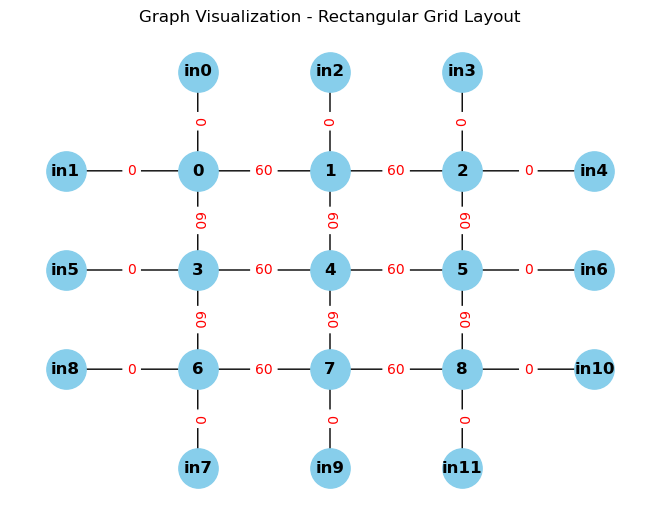

In [157]:
# test env
duration = 100
lanes = ['F', 'L', 'R']
directions = ['N', 'E', 'S', 'W']
A = [(['E', 'W'], ['F']), (['E', 'W'], ['L']), 
    (['N', 'S'], ['F']), (['N', 'S'], ['L']), 
    (['E'], ['F', 'L']), (['W'], ['F', 'L']), 
    (['N'], ['F', 'L']), (['S'], ['F', 'L'])]
vehicle_parameters = {'duration': duration, 'min_speed': 2.22, 'max_speed': 13.33, 
                      'lanes': lanes, 'arrival_rates': {'E': 5/60, 'N': 5/60, 'W': 10/60, 'S': 7/60}}
intersection_parameters = {'duration': duration, 'action_duration': 10, 
                           'Lanes': lanes, 'Directions': directions, 'A': A, 
                           'gamma': 0.95, 'alpha': 0.1, 'espilon': 0.1, 'is_mem_based':False,  
                           'is_dynamic_action_duration': False, 'dynamic_action_duration': 4, 
                           'reward_function': calculate_reward_default, 'n_vehicle_leaving_per_lane': 1}
graph_structure_params = {'rows': 3, 'cols': 3, 'length': 60}




env_SARSA = Env(duration=duration, graph_structure_parameters=graph_structure_params, 
          vehicle_parameters=vehicle_parameters, intersection_parameters=intersection_parameters)




TODOs
- congestion metric for all intersections


In [152]:
for v in env_SARSA.graph.nodes['0'].intersection.vehicles['N', 'L']:
    print(v.node_times)

  node arrival_direction arrival_lane arrival_time departure_time
0    0                 N            L     4.643008            NaN
1    1                 W            R          NaN            NaN
2    4                 N            F          NaN            NaN
3    7                 N            F          NaN            NaN
  node arrival_direction arrival_lane arrival_time departure_time
0    0                 N            L    21.625205            NaN
1    1                 W            F          NaN            NaN
2    2                 W            R          NaN            NaN
3    5                 N            L          NaN            NaN
  node arrival_direction arrival_lane arrival_time departure_time
0    0                 N            L    22.724294            NaN
1    1                 W            F          NaN            NaN
2    2                 W            L          NaN            NaN
  node arrival_direction arrival_lane arrival_time departure_time
0    0    

In [158]:
env_SARSA.SARSA_run(n_episodes=1)
# env_SARSA.plot_env()

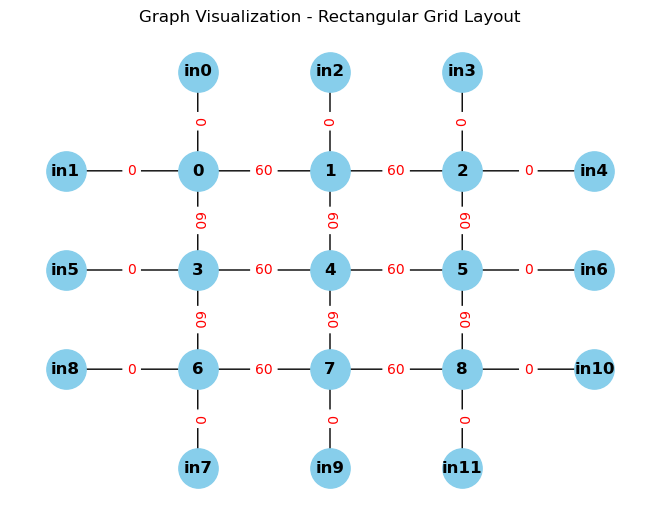

  node arrival_direction arrival_lane arrival_time departure_time
0    0                 N            L     0.982351            NaN
1    1                 W            L          NaN            NaN
  node arrival_direction arrival_lane arrival_time departure_time
0    0                 N            L    14.057041            NaN
1    1                 W            F          NaN            NaN
2    2                 W            R          NaN            NaN
3    5                 N            F          NaN            NaN
4    8                 N            L          NaN            NaN
  node arrival_direction arrival_lane arrival_time departure_time
0    0                 N            L    16.720499            NaN
1    1                 W            F          NaN            NaN
2    2                 W            R          NaN            NaN
3    5                 N            F          NaN            NaN
4    8                 N            F          NaN            NaN
  node arr

In [159]:
test_graph, test_vehicles = env_SARSA.generate_test_structures(graph_structure_parameters=graph_structure_params, 
                                                               vehicle_parameters=vehicle_parameters, 
                                                               intersection_parameters=intersection_parameters)

for v in test_graph.nodes['0'].intersection.vehicles[('N', 'L')]:
    print(v.node_times)

In [160]:
env_SARSA.test(test_graph=test_graph, test_vehicles=test_vehicles)

  node arrival_direction arrival_lane arrival_time departure_time
0    0                 N            L     0.982351            NaN
1    1                 W            L          NaN            NaN
  node arrival_direction arrival_lane arrival_time departure_time
0    0                 N            L    14.057041            NaN
1    1                 W            F          NaN            NaN
2    2                 W            R          NaN            NaN
3    5                 N            F          NaN            NaN
4    8                 N            L          NaN            NaN
  node arrival_direction arrival_lane arrival_time departure_time
0    0                 N            L    16.720499            NaN
1    1                 W            F          NaN            NaN
2    2                 W            R          NaN            NaN
3    5                 N            F          NaN            NaN
4    8                 N            F          NaN            NaN
  node arr

Images combined and saved as 'plots/combined/Intersection1.png'


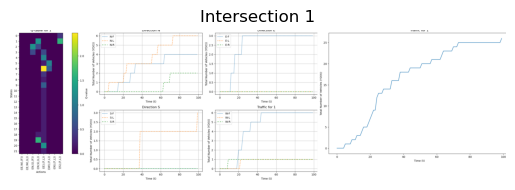

In [161]:
env_SARSA.graph.nodes['1'].intersection.plot_all()